<a href="https://colab.research.google.com/github/esteban-santiago/MachineLearning/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Définir un objectif mesurable 

#2) E.D.A: (Exploration Data Analysis)

#3) Preprocessing

#4) Modelling 

In [0]:
import numpy as np
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


**Dataset**: Covid-19 from kaggle

In [0]:
data = pd.read_excel('../content/drive/My Drive/Colab Notebooks/covid-19_v1/data/covid-19.xlsx')
df = data.copy()

#**1) Définir un objectif mesurable**
##**Objectif**: Prédire si une oersonne est infectée en fonctione des données cliniques disponibles
##**Métriques**: Accuracy 90% --> (Précision, Recall (Sensibilité, Score F1). F1: 50% ; Recall: 70% 

# **2) E.D.A.**:

##**Objectif**: Cromprendre au maximun les données dont on dispose pour bien définir une strategie de modelisation.

##**Checklist de la base (non-exhaustive)**

###*Analyse de la forme:*

1. Identification de la target: **"SARS-Cov-2 exam result"**
2. Nombre de lignes et de colomnes: 5644 x 111
3. Type de variables: df.dtypes.value_counts() -> 

    * qualitatives 70
    * quantitatives: 41


      3.1. Variables discretes (Boxplot)
      3.2. Variables continues (Histogramme)
4. Identification des valeurs manquantes: *beaucoup de NaN (moitié des variables > 90% de NaN)*

      2 groupes de données:
      * 76% -> Test viral
      * 89% -> taux sanguins



###*Analyse du fond:*

1. Visualisation de la target (Histogramme/Boxplot)
    
      ---> 10% de cas positifs 

      - Variables continues standardisées, skewed (asymétriques), test sanguin.
      - age quantile: difficile à interpreter
      - variable qualitative: binaire (0,1), viral, rhinovirus qui semble très élevée.
2. Compréhension des differentes variables (Internet)
3. Visualisation des relations features-target (Histogramme/Boxplot)
  - Création de sous-ensembles positifs et négatifs
  - Création de sous-ensembles blood et viral
  ### Relations
  - target / blood: les taux de Monocytes, Platelets, Leukocytes semblent liés au covid-19 (Ensembles de données differentes pour négatif et positif) --> hypothese à tester
  - target / age: les individus de faible age sont très peu contaminés? -> attention, on ne connait pas l'age. Variable interessante à comparer avec les résultats de tests sanguins
  - target / viral: les doubles maladies sont très rare. Rhinovirus/Enterovirus positif - covid-19 négatif?-> hypothese à tester.

  ### Analyse plus détaillé
  
  ### Relation / variable
  - blood_data / blood_data: certaines variables sont très corrélées: +0.9
  - blood_data / age : très faible correlation
  - viral / viral: influeza rapid test donne de mauvais résultats 
  - maladie / blood_data: Les taux sanguins entre malades et covid-19 sont différents 
  - hospitalisation / est malade
  - hospitalisation / blood_data: intéressant dans le cas ou on voudrait prédire dans quelle service un patient devrait aller

  ### NaN analyse
  - Si on voudrait éliminer les NaN on n'aurait que 99 valeurs 
  - viral: 1350 (92/8), blood: 600 (87/13), both: 90

## Hypothese Nulle (H0) - Rejetée
  - Les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativements différents.
      - H0 = Les taux moyens sont ÉGAUX chez les individus positifs et négatifs
  - Les individus atteints d'une quelconque maladie ont des taux significativement différents  


4. Identification des outliers

In [0]:
#Presets
pd.set_option('display.max_row', 111) #Display 111 rows
pd.set_option('display.max_columns', 111) #Display 111 columns

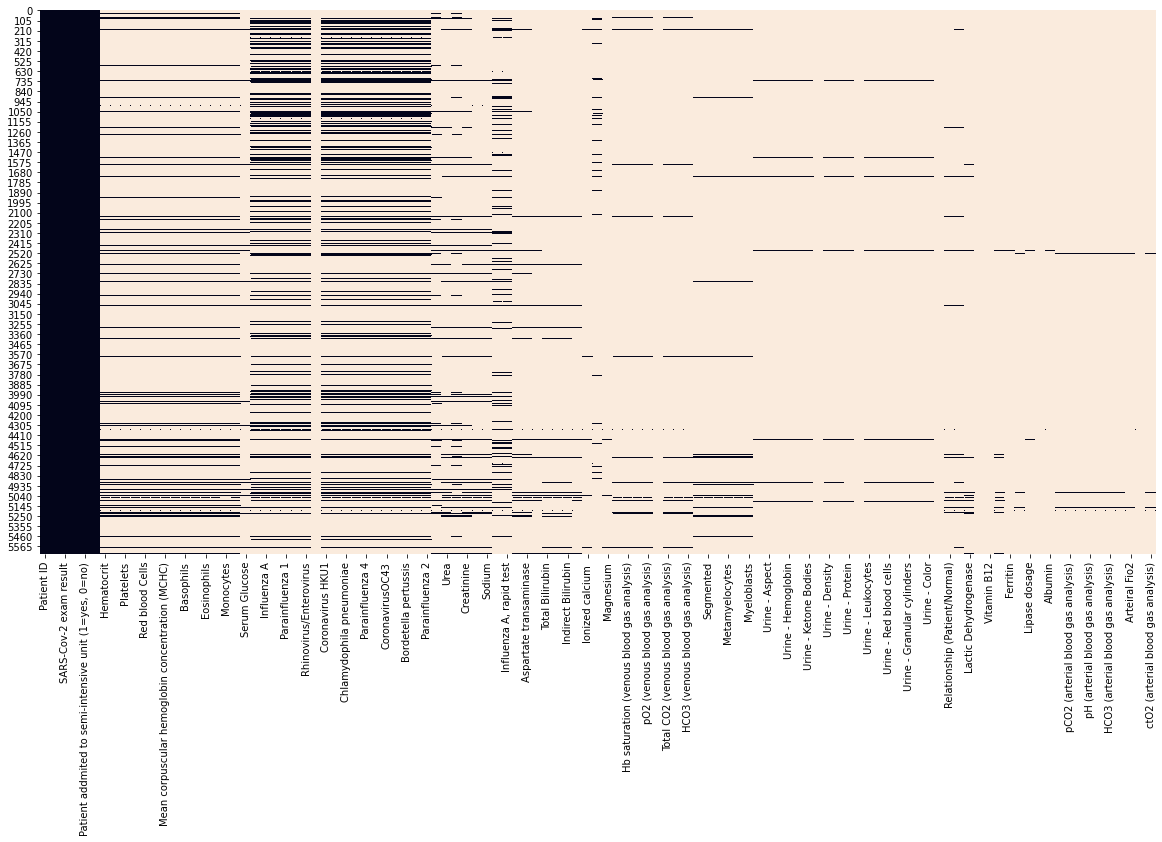

In [102]:
#E.D.A
#df.dtypes.value_counts().plot.pie()
plt.figure(figsize=(20,10)) #Size for graphs
sns.heatmap( df.isna(), cbar=False )



In [0]:
#2) E.D.A
#df.isna() retourne un array indexé et .sum() fait la summatoire des valeurs. 
#J'ai fait le pourcentage et ensuite on ordone les valeurs.
#Analise de fond - Visualisation initiale - Élimination des colonnes inutiles
df = df[df.columns[(df.isna().sum()/df.shape[0]) < 0.9]]
#plt.figure(figsize=(20,10)) #Size for graphs
#sns.heatmap( df.isna(), cbar=False )
#Eliminer une colonnes qui ne serve à rien
df = df.drop('Patient ID', axis=1)

In [0]:
#Normalize=True pour montrer les ciffres en pourcentages
df['SARS-Cov-2 exam result'].value_counts(normalize=True)

In [0]:
for col in df.select_dtypes('float'):
  plt.figure()
  sns.distplot(df[col]) #distribution plot.. une courbe de distribution 

In [0]:
#Variables quantitatives
df['Patient age quantile'].value_counts()


In [137]:
#Variables qualitatives (discrètes)
#Liste de valeurs pour chaque objet
for col in df.select_dtypes('object'):
  print(f'{col :-<50} {df[col].unique()}')

SARS-Cov-2 exam result---------------------------- ['negative' 'positive']
Respiratory Syncytial Virus----------------------- [nan 'not_detected' 'detected']
Influenza A--------------------------------------- [nan 'not_detected' 'detected']
Influenza B--------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 1----------------------------------- [nan 'not_detected' 'detected']
CoronavirusNL63----------------------------------- [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus---------------------------- [nan 'detected' 'not_detected']
Coronavirus HKU1---------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 3----------------------------------- [nan 'not_detected' 'detected']
Chlamydophila pneumoniae-------------------------- [nan 'not_detected' 'detected']
Adenovirus---------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 4----------------------------------- [nan 'not_detected' 'detected']
Coronavirus2

In [0]:
#Variables qualitatives (discrètes)
#Liste de valeurs pour chaque objet
for col in df.select_dtypes('object'):
  plt.figure()
  df[col].value_counts().plot.pie()

In [0]:
#Création de sous-ensembles positifs et négatifs
positive_df = df[df['SARS-Cov-2 exam result'] == 'positive']
negative_df = df[df['SARS-Cov-2 exam result'] == 'negative']


In [0]:
#Creation de sous-ensemble Blood et viral
missing_rate = df.isna().sum() / df.shape[0]
blood_columns = df.columns[(missing_rate < 0.9) & (missing_rate > 0.88)]
viral_columns = df.columns[(missing_rate < 0.88) & (missing_rate > 0.75)]

In [0]:
#Relation target-variables
##Target-blood
for col in blood_columns:
  plt.figure()
  sns.distplot(positive_df[col], label='positive')
  sns.distplot(negative_df[col], label='negative')
  plt.legend()

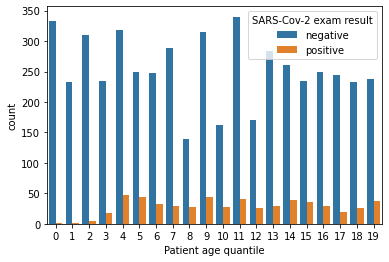

In [158]:
#Relation target-variables
##Target-age
sns.countplot(x='Patient age quantile', hue='SARS-Cov-2 exam result', data=df)

In [159]:
#Relation target-variables
##Target-viral
pd.crosstab(df['SARS-Cov-2 exam result'], df['Influenza A'])

Influenza A,detected,not_detected
SARS-Cov-2 exam result,,
negative,18,1224
positive,0,112


In [0]:
for col in viral_columns:
  plt.figure()
  sns.heatmap(pd.crosstab(df['SARS-Cov-2 exam result'], df[col]), annot=True, fmt='d')

In [0]:
#Analyse plus avancée
#Relation variables/variables
#taux sanguin
sns.pairplot(df[blood_columns])


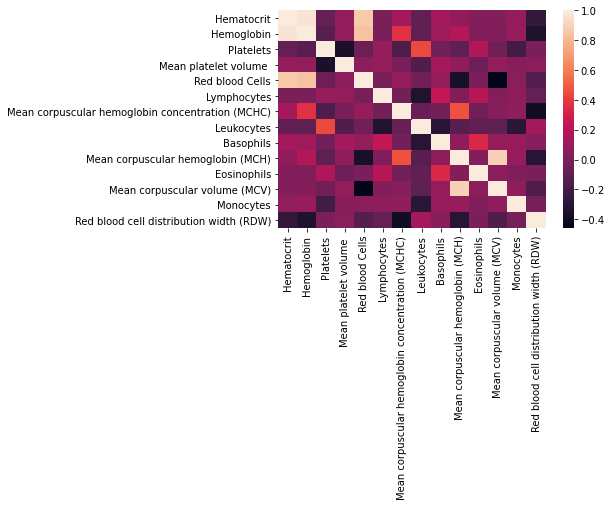

In [162]:
sns.heatmap(df[blood_columns].corr())

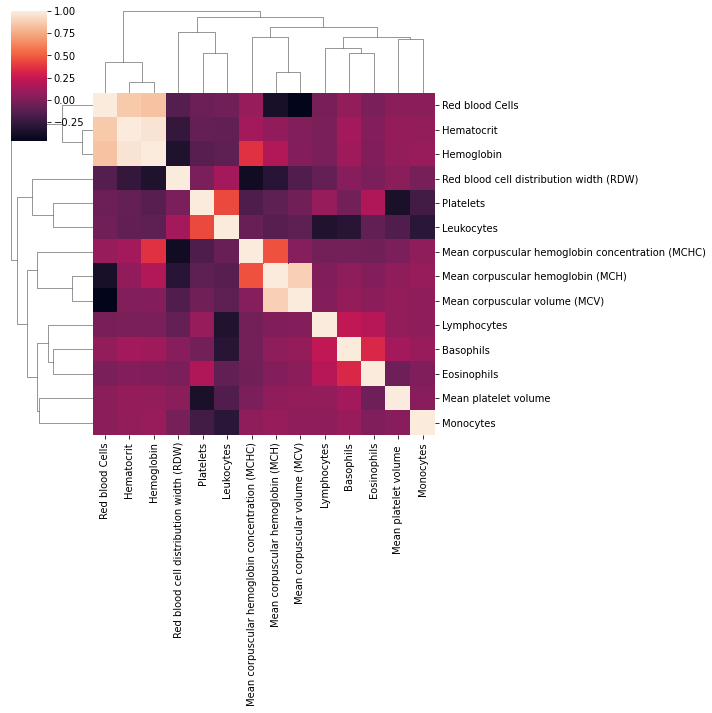

In [163]:
sns.clustermap(df[blood_columns].corr())

In [0]:
#Analyse plus avancée
#Relation variables/variables
#blood_data / age
for col in blood_columns:
  plt.figure()
  sns.lmplot(x='Patient age quantile', y = col, hue= 'SARS-Cov-2 exam result', data=df)


In [169]:

df.corr()['Patient age quantile'].sort_values()

Leukocytes                                              -0.166386
Platelets                                               -0.158683
Lymphocytes                                             -0.125935
Mean corpuscular hemoglobin concentration (MCHC)        -0.124671
Red blood Cells                                         -0.037510
Patient addmited to intensive care unit (1=yes, 0=no)   -0.035772
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.015736
Eosinophils                                              0.022085
Patient addmited to regular ward (1=yes, 0=no)           0.046166
Monocytes                                                0.050962
Hemoglobin                                               0.060320
Hematocrit                                               0.096808
Basophils                                                0.107525
Mean platelet volume                                     0.119449
Red blood cell distribution width (RDW)                  0.166429
Mean corpu

In [172]:
#Analyse plus avancée
#Relation variables/variables
# viral / viral: Relation entre Influenza et rapid test
print(pd.crosstab(df['Influenza A'], df['Influenza A, rapid test']))
print(pd.crosstab(df['Influenza B'], df['Influenza B, rapid test']))

Influenza A, rapid test  negative  positive
Influenza A                                
detected                        2         4
not_detected                  245        15
Influenza B, rapid test  negative  positive
Influenza B                                
detected                       18        11
not_detected                  233         4


In [0]:
#Analyse plus avancée
#Relation variables/variables
# viral / sanguin
#Création d'une nouvelle variable "est malade"
#[:-2] -> supprime les deux dernières colonnes
df['est malade'] = np.sum(df[viral_columns[:-2]] == 'detected', axis=1) >= 1
malade_df = df[df['est malade'] == True]
non_malade_df = df[df['est malade'] == False]

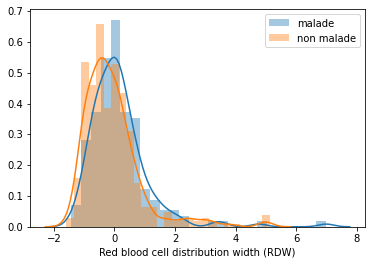

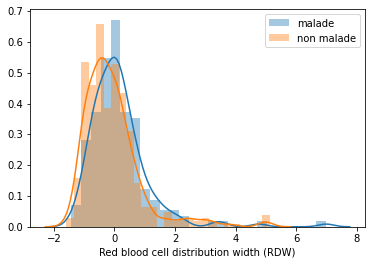

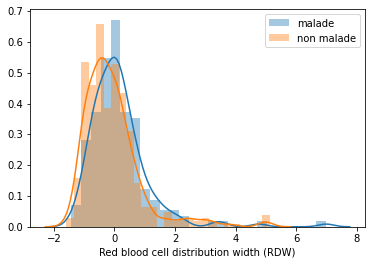

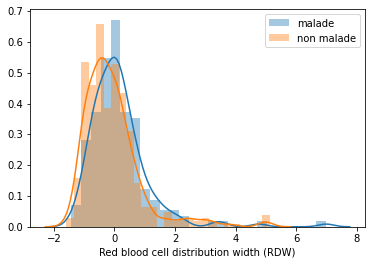

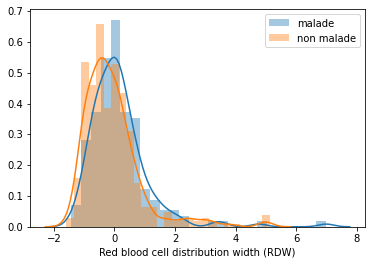

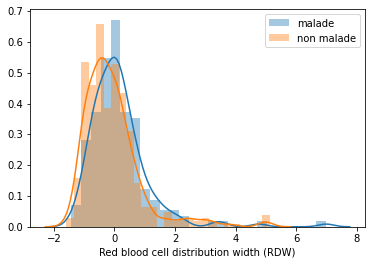

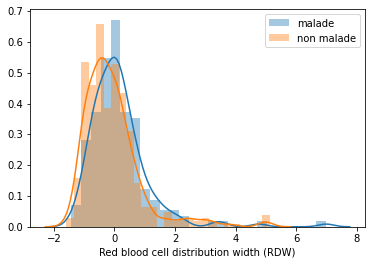

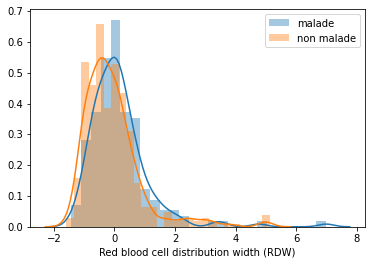

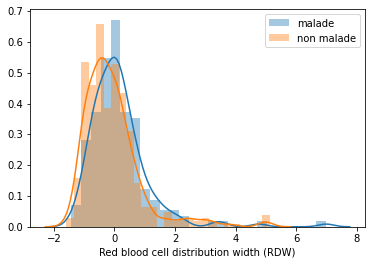

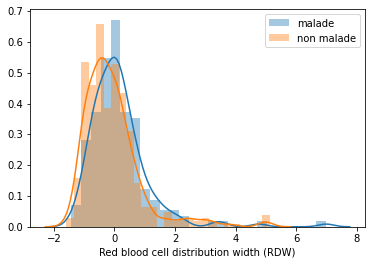

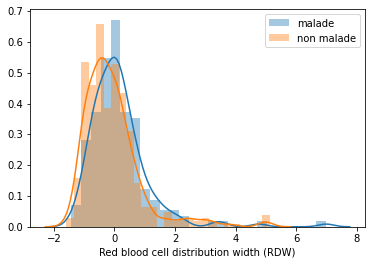

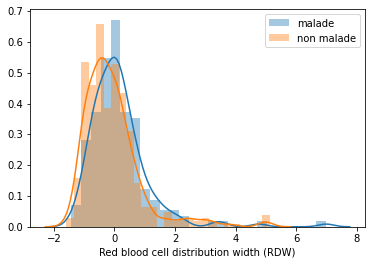

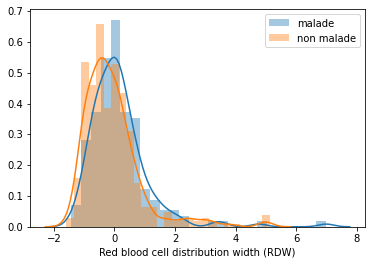

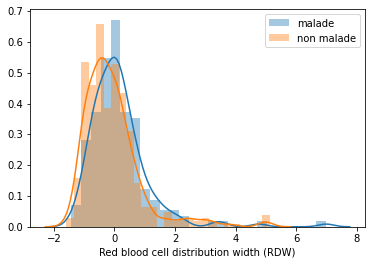

In [192]:
for cols in blood_columns:
  plt.figure()
  sns.distplot(malade_df[col], label="malade")
  sns.distplot(non_malade_df[col], label="non malade")
  plt.legend()

In [0]:
#Analyse plus avancée
#Relation variables/variables
# hospitalisation / "est malade"
def hospitalisation(df):
  if df['Patient addmited to regular ward (1=yes, 0=no)'] == 1:
    return 'surveillance'
  elif df['Patient addmited to semi-intensive unit (1=yes, 0=no)'] == 1:
    return 'soins semi-intensifs'
  elif df['Patient addmited to intensive care unit (1=yes, 0=no)'] == 1:
    return 'soins intensifs'
  else:
    return 'inconnu'

In [0]:
df['statut'] = df.apply(hospitalisation, axis=1)

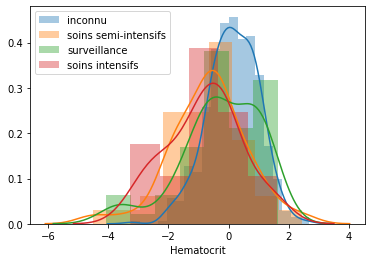

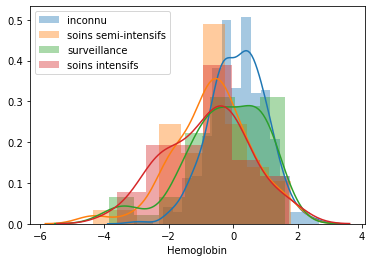

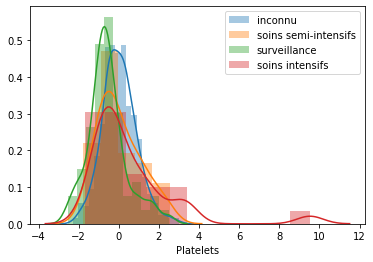

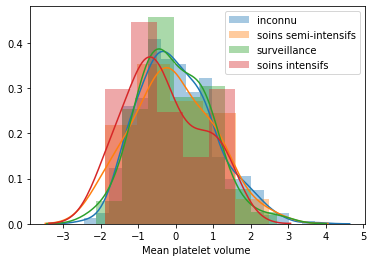

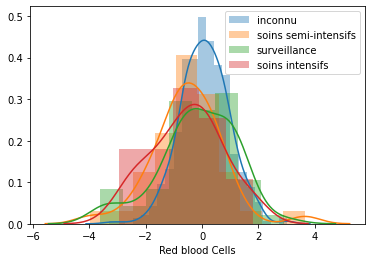

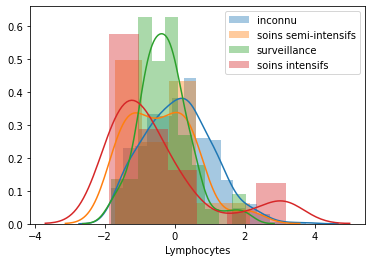

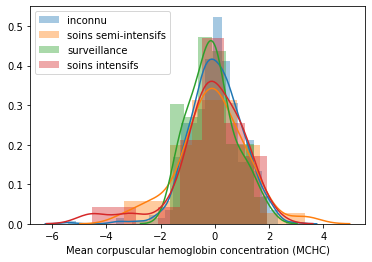

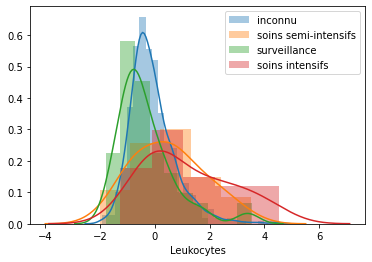

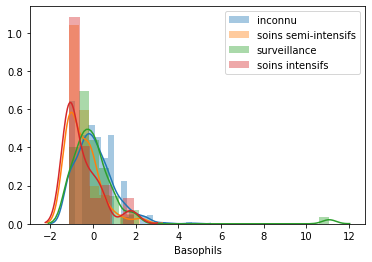

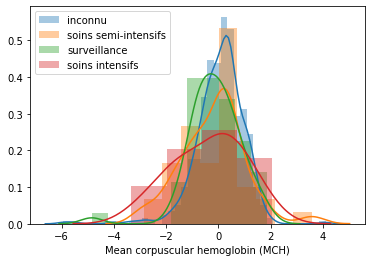

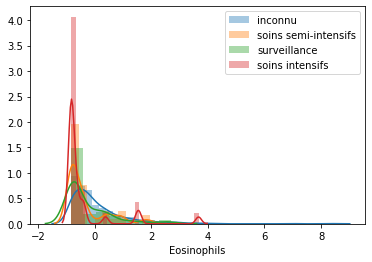

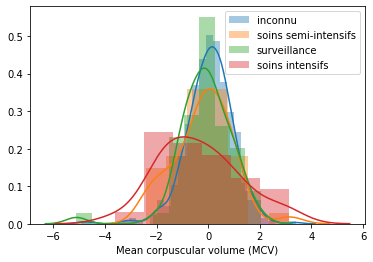

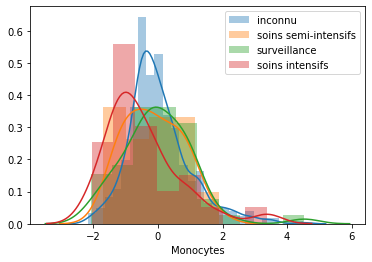

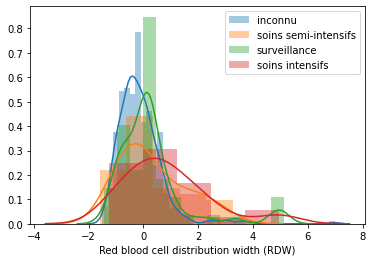

In [202]:
for col in blood_columns:
  plt.figure()
  for cat in df['statut'].unique():
    sns.distplot(df[df['statut'] == cat][col], label=cat)
  plt.legend()


In [205]:
### NaN analyse
df.dropna().count()
df[blood_columns].count()
df[viral_columns].count()

Respiratory Syncytial Virus    1354
Influenza A                    1354
Influenza B                    1354
Parainfluenza 1                1352
CoronavirusNL63                1352
Rhinovirus/Enterovirus         1352
Coronavirus HKU1               1352
Parainfluenza 3                1352
Chlamydophila pneumoniae       1352
Adenovirus                     1352
Parainfluenza 4                1352
Coronavirus229E                1352
CoronavirusOC43                1352
Inf A H1N1 2009                1352
Bordetella pertussis           1352
Metapneumovirus                1352
Parainfluenza 2                1352
Influenza B, rapid test         820
Influenza A, rapid test         820
dtype: int64

In [209]:
### NaN analyse
#Variable target
df1 = df[viral_columns[:-2]]
df1['covid'] = df['SARS-Cov-2 exam result']
df1.dropna()['covid'].value_counts(normalize=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


negative    0.91716
positive    0.08284
Name: covid, dtype: float64

In [210]:
df1 = df[blood_columns[:-2]]
df1['covid'] = df['SARS-Cov-2 exam result']
df1.dropna()['covid'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


negative    0.864775
positive    0.135225
Name: covid, dtype: float64

In [0]:
#Test hypothese H0

balanced_ned = negative_df.sample(positive_df.shape[0])


In [0]:
def t_test(col):
  alpha = 0.02
  stat, p = ttest_ind(balanced_ned[col].dropna(), positive_df[col].dropna())
  if p < alpha:
    return 'H0 Rejetée'
  else:
    return 0

In [220]:
for col in blood_columns:
  print(f'{col :-<50} {t_test(col)}')

Hematocrit---------------------------------------- 0
Hemoglobin---------------------------------------- 0
Platelets----------------------------------------- H0 Rejetée
Mean platelet volume ----------------------------- H0 Rejetée
Red blood Cells----------------------------------- H0 Rejetée
Lymphocytes--------------------------------------- 0
Mean corpuscular hemoglobin concentration (MCHC)-- 0
Leukocytes---------------------------------------- H0 Rejetée
Basophils----------------------------------------- 0
Mean corpuscular hemoglobin (MCH)----------------- 0
Eosinophils--------------------------------------- H0 Rejetée
Mean corpuscular volume (MCV)--------------------- 0
Monocytes----------------------------------------- H0 Rejetée
Red blood cell distribution width (RDW)----------- 0


#**3) Pre-processing:**

##**Objectif:** Transformer le data pour le mettre dans un format propice au Machine Learning.

##**Checklist de la base**: (Non-exhaustive)

1. Création du Train set / Test set
2. Élimination des NaN: dropna(), imputation, colonnes vides
3. Encodage
4. Suppresion des outliers néfastes au modèle
5. Feature selection
6. Feature engineering
7. Feature scaling  



In [0]:
#Pre-Processing

#**4) Modelling**:

##**Objectif**: Développer un modèle de machine learning qui corresponde à l'objectif final.

##**Checklist de la base**: (Non-exhaustive)


1. Définir une fonction d'évaluation
2. Entrenaiment des differents modèles
3. Optimisation avec GridSearchCV
(Optionnel) Analyse des erreurs et retour au Prepocessing/EDA
4. Learning Curve et prise de décision 

In [0]:
#Modelling